In [2]:
import cv2
from glob import glob
import numpy as np
import pandas as pd
from time import time
import ast
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import argparse
import imutils
import random
import math
import os
import dlib
from scipy.interpolate import interp2d

from phase1.Misc.utils import *
from phase1.dTriangulation import *
from phase1.ThinPlateSpline import *

from phase2.api import PRN
from phase2.prnet import *
from utils.render import render_texture

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Do for an Image Pair

DelTri


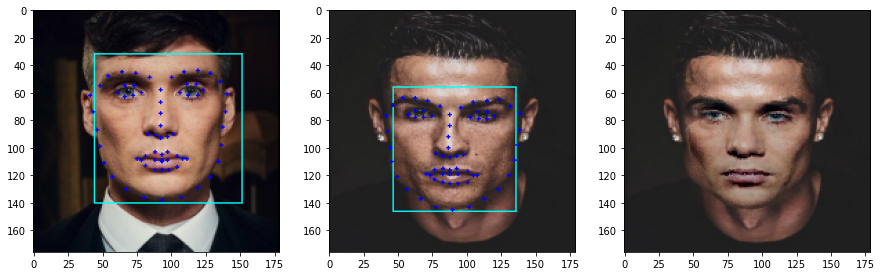

In [11]:
path_to_shape_predictor = './phase1/Misc/shape_predictor_68_face_landmarks.dat'
path_to_image = "../Data/"
path_to_image1 = path_to_image+ "Face1.jpg"
path_to_image2 =  path_to_image + "Face2.jpg"

Face1, Face2 = readImages(path_to_image1, path_to_image2)
grayFace1 = cv2.cvtColor(Face1, cv2.COLOR_BGR2GRAY)
grayFace2 = cv2.cvtColor(Face2, cv2.COLOR_BGR2GRAY)

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(path_to_shape_predictor)

    
# get bounding box of face
N_pyrLayers = 1
box1 = detector(grayFace1,N_pyrLayers)[0]
# box2 = detector(grayFace2,N_pyrLayers)[0]
try:
    box2 = detector(grayFace2,N_pyrLayers)[0]
except IndexError as e:
    print(e)
    sys.exit(1) 

############################# For any two given Faces, do swapping #############################
method = 'DelTri'

## detect the facial markers
if method == 'TPS':
    print('TPS')
    WarpedFace, Face1_print, Face2_print = FaceSwap_TPS(Face1,Face2, box1,box2, predictor)

elif method == 'DelTri':
    print('DelTri')
    WarpedFace, Face1_print, Face2_print = FaceSwap_delTri(Face1,Face2, box1,box2, predictor)

# elif method = 'PrNet':
    

_, plts = plt.subplots(1,3,figsize=(15,5))
plts[0].imshow(Face1_print)
plts[1].imshow(Face2_print)
plts[2].imshow(WarpedFace)

### Face on video destination

In [3]:
path_to_shape_predictor = './phase1/Misc/shape_predictor_68_face_landmarks.dat'
path_to_image = "../Data/TestSet/"
VideoFilePath = path_to_image+ "Test1.mp4"
SaveFileName = "output_Rambo.mp4"
RefImageFilePath = path_to_image + 'Rambo.jpg'

method = 'DelTri'

##### Setting up reference image ######
print('Setting up reference image.......')
FaceRef = cv2.imread(RefImageFilePath) ## color image
ref_h,ref_w = FaceRef.shape[:2]


if method!='PRNet':
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(path_to_shape_predictor)
    
    grayFaceRef = cv2.cvtColor(FaceRef, cv2.COLOR_BGR2GRAY) ## gray image
    N_pyrLayers = 1
    boxRef = detector(grayFaceRef,N_pyrLayers) ## reference bounding box
    if len(boxRef)!=1:
        print('Cannot find face in reference Image... exiting... :( ', len(boxRef))
        exit()
    else:
        boxRef = boxRef[0]
        
elif method == 'PRNet':
    prn = PRN(is_dlib = True)    
    
    
##### Setting up video ######
cap = cv2.VideoCapture(VideoFilePath)
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4))
result = cv2.VideoWriter(SaveFileName,  
                        cv2.VideoWriter_fourcc(*'DIVX'), 
                        10, (ref_w, ref_h)) 

facemarksFrames = []
## run the loop
while(True):    
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    
    frame = cv2.resize(frame, (ref_w,ref_h))
    
    if method == 'PRNet':
        WarpedFace = FaceSwap_DL(prn, frame, FaceRef)
        
    else:
        grayFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        boxFrame = detector(grayFrame, N_pyrLayers)
        
        elif len(boxFrame)>1:
            margin = 50
            boxRef,boxFrame  = boxFrame[0], boxFrame[1]
            FaceFrame = FaceFrame[rects[1].top()-margin:rects[1].bottom()+margin,rects[1].left()-margin:rects[1].right()+margin,:]
            FaceRef = FaceRef[rects[0].top()-margin:rects[0].bottom()+margin,rects[0].left()-margin:rects[0].right()+margin,:]
            
        elif len(boxFrame) == 1:

            boxFrame = boxFrame[0]
            
            ## get only the facefiducials
            facemarksFrame, _, _ = FaceDetector(frame, boxFrame, predictor)
            facemarksFrames.append(facemarksFrame)

            ## detect the facial markers
            if method == 'TPS':

                WarpedFace, FaceRef_print, FaceFrame_print = FaceSwap_TPS(FaceRef,frame, boxRef, boxFrame, predictor)

            elif method == 'DelTri':

                WarpedFace, FaceRef_print, FaceFrame_print = FaceSwap_delTri(FaceRef,frame, boxRef, boxFrame, predictor)
        else:
            WarpedFace = frame
            text_location = (ref_w-400, ref_h-42)
            WarpedFace = cv2.putText(WarpedFace, 'Cannot Find Face',text_location, cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0) ,3, cv2.LINE_AA, False)

    cv2.imshow('frame', WarpedFace)
    result.write(np.uint8(WarpedFace))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
result.release() 
cv2.destroyAllWindows()

Setting up reference image.......
Stream ended..


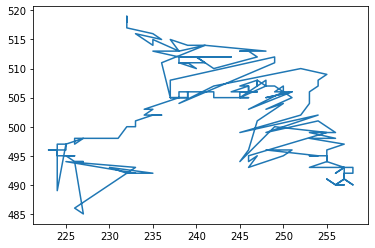

In [31]:
i = 0
pointTraj = np.array(facemarksFrames)[:,i,:]
plt.plot(pointTraj[:,1],pointTraj[:,0])

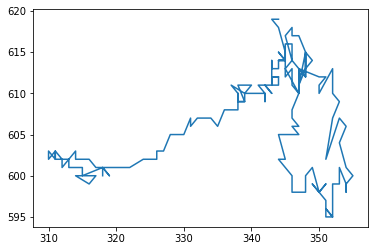

In [30]:
plt.plot(pointTraj[:,1],pointTraj[:,0])

In [32]:
prev_pt = 0
for i in range(len(pointTraj)-1):
    
    

array([[518, 232],
       [519, 232],
       [517, 232],
       [516, 235],
       [516, 235],
       [515, 236],
       [516, 233],
       [514, 235],
       [515, 235],
       [513, 238],
       [513, 235],
       [512, 238],
       [512, 240],
       [512, 238],
       [512, 240],
       [512, 238],
       [511, 238],
       [511, 239],
       [511, 238],
       [510, 240],
       [511, 239],
       [511, 238],
       [511, 240],
       [511, 241],
       [512, 240],
       [512, 243],
       [512, 244],
       [512, 240],
       [510, 242],
       [510, 242],
       [512, 247],
       [513, 246],
       [513, 246],
       [513, 245],
       [513, 248],
       [514, 241],
       [514, 239],
       [515, 237],
       [513, 238],
       [514, 241],
       [511, 236],
       [505, 237],
       [508, 237],
       [512, 249],
       [511, 249],
       [504, 238],
       [507, 242],
       [510, 252],
       [509, 255],
       [508, 254],
       [507, 254],
       [507, 254],
       [506,